In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

California dataset 

In [2]:
data = pd.read_csv('data/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [5]:
data.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype=object)

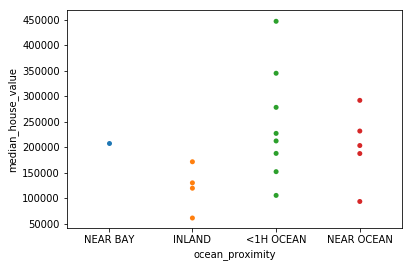

In [6]:
sns.stripplot(x='ocean_proximity',y='median_house_value',data=data[data['total_rooms']==1527.0])

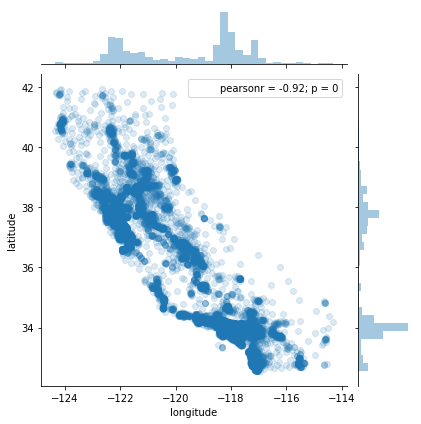

In [8]:
sns.jointplot(data.longitude, data.latitude, alpha=.15)

### Missing Values

In [9]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

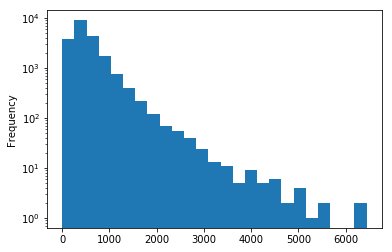

In [10]:
data.total_bedrooms.plot(kind='hist', bins=25, log=True)

In [11]:
# Fill Nan
data.total_bedrooms.fillna(data.total_bedrooms.median(), inplace=True)

### Normalizing Data

In [12]:
#Normalizing Features
data['room_per_household'] = data.total_rooms/data.households
data['bedroom_per_household'] = data.total_bedrooms/data.households
data['household_pop'] = data.population/data.households

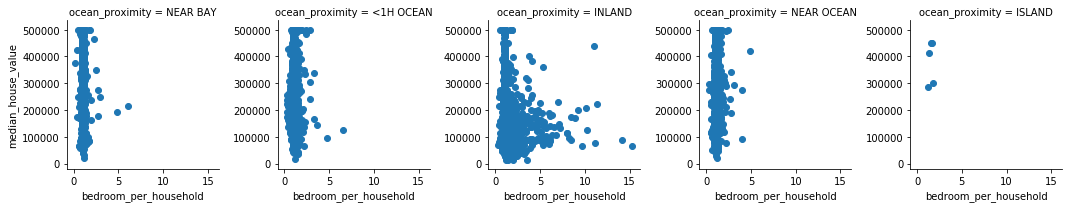

In [13]:
d = data[data.bedroom_per_household<20]
g = sns.FacetGrid(data=d,col='ocean_proximity')
g.map(plt.scatter,'bedroom_per_household','median_house_value')

In [14]:
def preprocess(data):
    # Fill missing values for total_bedrooms
    data.total_bedrooms.fillna(data.total_bedrooms.median(), inplace=True)

    # Flag new data containing missing values for other features 
    nulls = data.isnull().sum()
    for index, n in enumerate(nulls):
        if n != 0:
            print('There are {} missing values in column {} '.format(n, index))
        
    # Normalizing Features
    data['room_per_household'] = data.total_rooms/data.households
    data['bedroom_per_household'] = data.total_bedrooms/data.households
    data['household_pop'] = data.population/data.households

    # Deleting unwanted features

    return data

## Random Forest (no normalization)

In [15]:
X = data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']]
X = pd.get_dummies(data=X, columns=['ocean_proximity'])
y = data['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

In [16]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=500, max_depth=3, max_features=3, n_jobs=-1, random_state=73)
rfr.fit(X_train,y_train)
rfr.score(X_train,y_train)

0.49285428472430565

longitude                     0.073087
latitude                      0.085055
housing_median_age            0.021141
total_rooms                   0.027784
total_bedrooms                0.003357
population                    0.009466
households                    0.004144
median_income                 0.410802
ocean_proximity_<1H OCEAN     0.065284
ocean_proximity_INLAND        0.266248
ocean_proximity_ISLAND        0.000023
ocean_proximity_NEAR BAY      0.017318
ocean_proximity_NEAR OCEAN    0.016292
dtype: float64


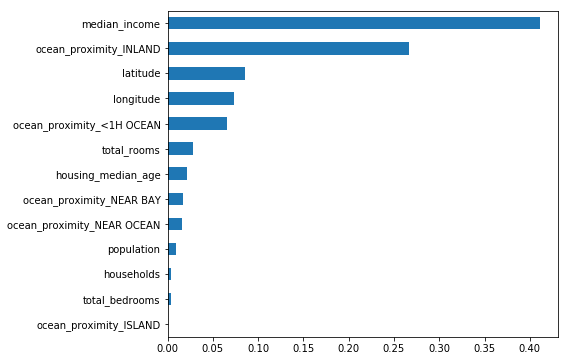

In [17]:
feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [18]:
rfr.score(X_train, y_train)

0.49285428472430565

In [19]:
rfr.score(X_test, y_test)

0.49111420496525915

#### Grid Search

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()

parameters = {'max_depth': range(3,9), 'max_features': range(2,9)}
grid_search = GridSearchCV(estimator=rf_regr, param_grid=parameters, cv=5, n_jobs=-1, return_train_score=True)

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.743
Best parameters set:
	max_depth: 8
	max_features: 7


longitude                     0.073087
latitude                      0.085055
housing_median_age            0.021141
total_rooms                   0.027784
total_bedrooms                0.003357
population                    0.009466
households                    0.004144
median_income                 0.410802
ocean_proximity_<1H OCEAN     0.065284
ocean_proximity_INLAND        0.266248
ocean_proximity_ISLAND        0.000023
ocean_proximity_NEAR BAY      0.017318
ocean_proximity_NEAR OCEAN    0.016292
dtype: float64


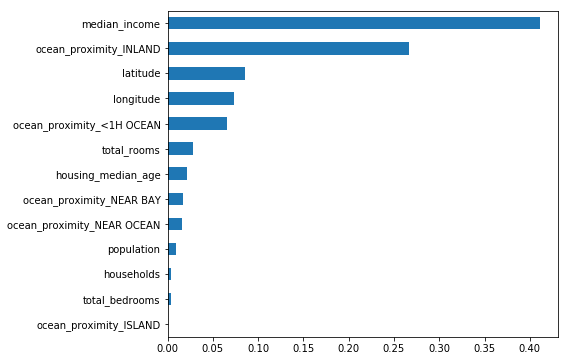

In [83]:
rfr2 = grid_search.best_estimator_
rfr2.fit(X_train,y_train)

feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [84]:
rfr2.score(X_train, y_train)

0.75380396965687391

In [85]:
rfr2.score(X_test, y_test)

0.73068476293558626

## Random Forest (with normalization)

In [123]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop'],
      dtype='object')

In [86]:
X = data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop']]
X = pd.get_dummies(data=X, columns=['ocean_proximity'])
y = data['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

#### Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(n_estimators=500)

parameters = {'max_depth': range(3,8), 'max_features': range(2,7)}
grid_search = GridSearchCV(estimator=rf_regr, param_grid=parameters, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.989
Best parameters set:
	max_depth: 7
	max_features: 6


longitude                      1.051907
latitude                       1.152931
housing_median_age             0.476846
total_rooms                    0.162811
total_bedrooms                 0.078118
population                     0.112195
households                     0.073736
median_income                 16.126506
median_house_value            66.245881
room_per_household             2.642244
bedroom_per_household          0.144493
household_pop                  2.085362
ocean_proximity_<1H OCEAN      0.944639
ocean_proximity_INLAND         8.499057
ocean_proximity_ISLAND         0.000701
ocean_proximity_NEAR BAY       0.098762
ocean_proximity_NEAR OCEAN     0.103811
dtype: float64


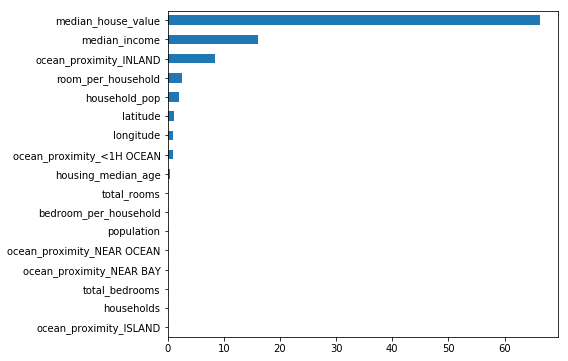

In [92]:
rfr2 = grid_search.best_estimator_
rfr2.fit(X_train,y_train)

feature_importances = pd.Series(rfr2.feature_importances_*100, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [93]:
rfr2.score(X_train, y_train)

0.99074950976888454

In [94]:
rfr2.score(X_test, y_test)

0.98867443899326579

## Random Forest (with normalization - excluding features)

In [133]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop'],
      dtype='object')

In [95]:
X = data[['longitude', 'latitude', 'housing_median_age',
       'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop']]
X = pd.get_dummies(data=X, columns=['ocean_proximity'])
y = data['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

#### Grid Search

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(n_estimators=500)

parameters = {'max_depth': range(4,8), 'max_features': range(4,7)}
grid_search = GridSearchCV(estimator=rf_regr, param_grid=parameters, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.993
Best parameters set:
	max_depth: 7
	max_features: 6


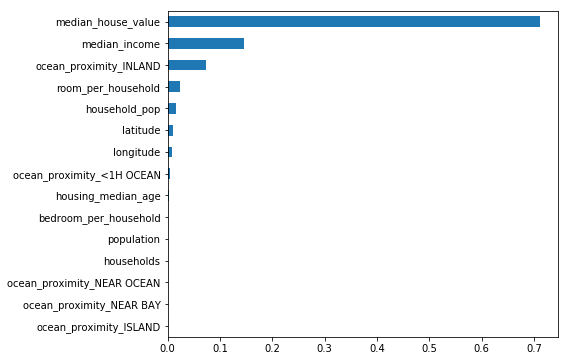

In [97]:
rfr2 = grid_search.best_estimator_
rfr2.fit(X_train,y_train)

feature_importances = pd.Series(rfr2.feature_importances_, index=X_train.columns)
#print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [98]:
rfr2.score(X_train, y_train)

0.99455634003668603

In [99]:
rfr2.score(X_test, y_test)

0.99326718851961815

## Model Evaluation Model Selection for RandomForest

In [109]:
#grid_search.grid_scores_

In [110]:
cv_res = grid_search.cv_results_
for k, v in cv_res.items():
    print('key: {}, type: {}, len: {}'.format(k, type(v), len(v)))

key: mean_fit_time, type: <class 'numpy.ndarray'>, len: 42
key: std_fit_time, type: <class 'numpy.ndarray'>, len: 42
key: mean_score_time, type: <class 'numpy.ndarray'>, len: 42
key: std_score_time, type: <class 'numpy.ndarray'>, len: 42
key: param_max_depth, type: <class 'numpy.ma.core.MaskedArray'>, len: 42
key: param_max_features, type: <class 'numpy.ma.core.MaskedArray'>, len: 42
key: params, type: <class 'list'>, len: 42
key: split0_test_score, type: <class 'numpy.ndarray'>, len: 42
key: split1_test_score, type: <class 'numpy.ndarray'>, len: 42
key: split2_test_score, type: <class 'numpy.ndarray'>, len: 42
key: split3_test_score, type: <class 'numpy.ndarray'>, len: 42
key: split4_test_score, type: <class 'numpy.ndarray'>, len: 42
key: mean_test_score, type: <class 'numpy.ndarray'>, len: 42
key: std_test_score, type: <class 'numpy.ndarray'>, len: 42
key: rank_test_score, type: <class 'numpy.ndarray'>, len: 42
key: split0_train_score, type: <class 'numpy.ndarray'>, len: 42
key: spli

In [120]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

cvres_df = pd.DataFrame()
cv_res = grid_search.cv_results_

for key, array in cv_res.items():
    if not hasNumbers(key):
        if type(array) == np.ndarray:
            cvres_df[key] = cv_res[key]
        elif type(array) == np.ma.core.MaskedArray:
            cvres_df[key] = cv_res[key].compressed()
            
cvres_df['score_difference'] = (cvres_df.mean_train_score - cvres_df.mean_test_score)

In [121]:
cvres_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score,score_difference
0,0.069300,0.023825,0.003201,0.000319,3,2,0.416580,0.035607,42,0.422376,0.034143,0.005796
1,0.108536,0.032054,0.002921,0.000341,3,3,0.478229,0.018158,41,0.483594,0.011647,0.005365
2,0.103121,0.036666,0.002701,0.000073,3,4,0.536321,0.010120,39,0.541304,0.005924,0.004983
3,0.089121,0.004774,0.002612,0.000061,3,5,0.555753,0.013393,35,0.561297,0.004103,0.005544
4,0.154174,0.040124,0.003967,0.002380,3,6,0.555470,0.018907,36,0.561440,0.014144,0.005970


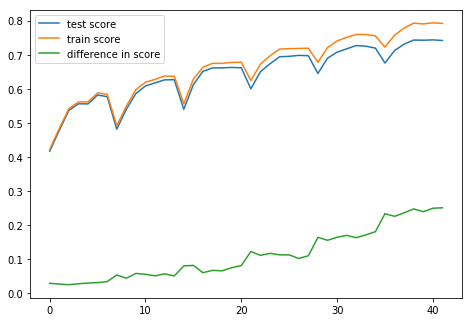

In [123]:
#cvres_df.mean_test_score.plot()

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.plot(cvres_df.index,cvres_df.mean_test_score,label='test score')
ax.plot(cvres_df.index,cvres_df.mean_train_score,label='train score')
ax.plot(cvres_df.index,cvres_df.score_difference*5,label='difference in score')

ax.legend(loc='best')

In [124]:
#sns.jointplot(x='param_max_depth', y='mean_test_score', data=cvres_df)

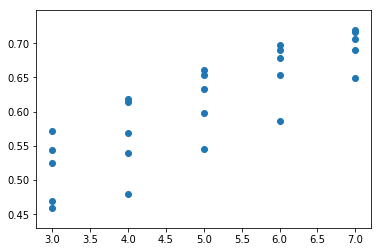

In [100]:
x = cvres_df['param_max_depth']
y = cvres_df['mean_test_score']
plt.scatter(x,y)

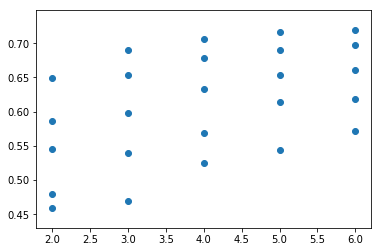

In [99]:
#sns.lmplot(x='param_max_depth', y='mean_test_score', data=cvres_df)
x = cvres_df['param_max_features']
y = cvres_df['mean_test_score']
plt.scatter(x,y)

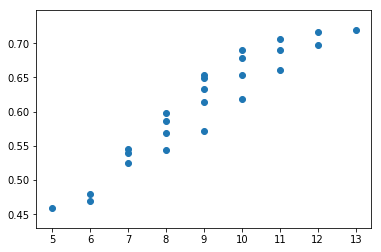

In [98]:
#sns.lmplot(x='param_max_depth', y='mean_test_score', data=cvres_df)
x = cvres_df['param_max_features'] + cvres_df['param_max_depth']
y = cvres_df['mean_test_score']
plt.scatter(x,y)

#### pipeline

In [35]:
from sklearn.pipeline import Pipeline

regr = RandomForestRegressor(n_estimators=500)
parameters = {'max_depth': range(4,8), 'max_features': range(5,7)}
gs = GridSearchCV(estimator=regr, param_grid=parameters, cv=10, n_jobs=-1)

pipeline = Pipeline([
    ('grid_search', gs)
])

pipeline.fit(X_train, y_train)
pipeline.score(X_train, y_train)

Pipeline(memory=None,
     steps=[('grid_search', GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, m...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [37]:
pipeline.score(X_test, y_test)

0.73775422380821065

In [ ]:
pipeline.

rfe vs rfecv

In [58]:
from sklearn.pipeline import Pipeline

regr = RandomForestRegressor(n_estimators=500)
parameters = {'max_depth': range(5,8), 'max_features': range(5,7)}
gs = GridSearchCV(estimator=regr, param_grid=parameters, cv=10, n_jobs=-1)

pipeline = Pipeline([
    ('grid_search', gs)
])

pipeline.fit(X_train, y_train)
pipeline.score(X_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

longitude                     0.093059
latitude                      0.074246
housing_median_age            0.030906
total_rooms                   0.013928
total_bedrooms                0.008267
population                    0.012374
households                    0.006635
median_income                 0.526330
ocean_proximity_<1H OCEAN     0.018213
ocean_proximity_INLAND        0.207477
ocean_proximity_ISLAND        0.000121
ocean_proximity_NEAR BAY      0.002420
ocean_proximity_NEAR OCEAN    0.006023
dtype: float64


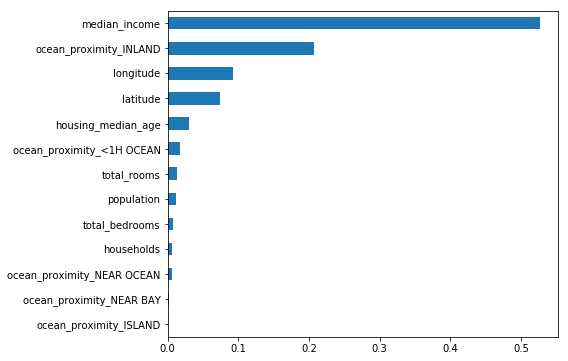

In [57]:
model = gs.best_estimator_.fit(X_train,y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [47]:
pipeline.predict(X_test)

array([ 262222.46132379,  207547.00241254,  242257.87868865, ...,
        143247.32160895,  178722.15738272,   73436.93450524])

In [48]:
model.predict(X_test)

array([ 262222.46132379,  207547.00241254,  242257.87868865, ...,
        143247.32160895,  178722.15738272,   73436.93450524])

In [50]:
model.score(X_train, y_train)

0.76115763045858587